In [ ]:
# Chennai power outage analysis using XGBoost by Sriparna Mondal

In [132]:
import pandas as pd
import numpy as np
import pickle
import streamlit as st
import prophet
import plotly.figure_factory as ff
import plotly.graph_objs  as go

from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot

In [133]:
daily_load_shedding_df = pd.read_csv('dayly_load_shedding_schedule_chennai_2014_2022.csv')
daily_load_shedding_df.shape

(479, 9)

In [134]:
daily_load_shedding_df.head()

,PO_day,PO_date,PO_start_time,PO_end_time,PO_posting_date,PO_posting_time,PO_duration(Hrs),PO_start_time_short,PO_end_time_short
0,Thursday,2022-04-07 00:00:00,1900-01-01 09:00:00,1900-01-01 14:00:00,2022-07-04 00:00:00,7:36:07 AM,5.0,09:00:00,14:00:00
1,Monday,2022-02-07 00:00:00,1900-01-01 09:00:00,1900-01-01 14:00:00,2022-07-01 00:00:00,8:45:31 AM,5.0,09:00:00,14:00:00
2,Friday,2022-01-07 00:00:00,1900-01-01 09:00:00,1900-01-01 14:00:00,2022-07-01 00:00:00,8:38:58 AM,5.0,09:00:00,14:00:00
3,Thursday,2022-06-30 00:00:00,1900-01-01 09:00:00,1900-01-01 14:00:00,2022-06-30 00:00:00,8:10:28 AM,5.0,09:00:00,14:00:00
4,Wednesday,2022-06-29 00:00:00,1900-01-01 09:00:00,1900-01-01 14:00:00,2022-06-28 00:00:00,3:47:10 PM,5.0,09:00:00,14:00:00


In [135]:
demand_supply_monthly_df = pd.read_csv('demand_supply_monthly.csv')
demand_supply_monthly_df.shape

(122, 17)

In [136]:
demand_supply_monthly_df.head()

,Requirement(MU/DAY),Energy_met(MU/DAY),Surplus(+)/Deficit(-)(MU/DAY),Requirement(MU),Energy_met(MU),Surplus(+)/Deficit(-)(MU),%Shortage(MU),Requirement(MW),Peak_Demand_Met5(MW),Surplus(+)/Deficit(-)(MW),%Shortage(MW),name_report,year,month,date_published,month_published,year_published
0,354.0,354.0,-0.9,10632.0,10605.0,-26.0,-0.2,17646.0,17563.0,-83.0,-0.5,Monthly_Report_Apr_2022,2022,4,2022-05-23,5,2022
1,337.0,337.0,0.0,10459.0,10458.0,-1.0,0.0,16906.0,16906.0,0.0,0.0,Monthly_Report_May_2022,2022,5,2022-06-23,6,2022
2,344.0,343.0,-0.3,10657.0,10648.0,-9.0,-0.1,17196.0,17196.0,0.0,0.0,Monthly_Report_Mar_2022,2022,3,2022-04-25,4,2022
3,286.0,286.0,0.0,8873.0,8873.0,1.0,0.0,15290.0,15290.0,0.0,0.0,Monthly_Report_Jan_2022,2022,1,2022-02-23,2,2022
4,245.0,245.0,0.0,7362.0,7360.0,-1.0,0.0,13501.0,13480.0,-21.0,-0.2,Monthly_Report_Nov_2021,2021,11,2021-12-23,12,2021


In [137]:
demand_supply_yearly_df= pd.read_csv('demand_supply_yearly.csv')
demand_supply_yearly_df.shape

(11, 12)

In [138]:
demand_supply_yearly_df.head()

,year,Requirement(MU/DAY),Energy_met(MU/DAY),Surplus(+)/Deficit(-)(MU/DAY),Requirement(MU),Energy_met(MU),Surplus(+)/Deficit(-)(MU),%Shortage(MU),Requirement(MW),Peak_Demand_Met5(MW),Surplus(+)/Deficit(-)(MW),%Shortage(MW)
0,2012,251.555556,207.555556,-44.222222,68906.0,56813.0,-12093.0,-17.777778,106715.0,92862.0,-13853.0,-12.666667
1,2013,256.416667,232.750000,-23.750000,93856.0,85185.0,-8671.0,-9.141667,145122.0,137615.0,-7507.0,-5.216667
2,2014,268.375000,259.991667,-8.383333,97625.1,94603.6,-3021.6,-3.066667,154358.4,153581.4,-776.0,-0.308333
3,2015,267.416667,263.283333,-4.125000,97604.2,96106.1,-1497.9,-1.500000,159628.0,156531.0,-3096.0,-1.891667
4,2016,293.458333,293.416667,-0.050000,107373.0,107357.4,-15.6,-0.008333,173636.0,173521.0,-115.0,-0.066667


In [139]:
electricity_consumption_df = pd.read_csv('electricity_consumption_consolidated.csv')
electricity_consumption_df.shape

(64, 5)

In [140]:
electricity_consumption_df.head()

,Category Id,Category,Consumption (M.U),Year,Consumers
0,1,Industries (including Traction),22790,2010,624472
1,2,Agriculture,11940,2010,1913697
2,3,Domestic,13709,2010,15565047
3,4,Commercial,5686,2010,2636821
4,5,Public Lighting and Water works,1043,2010,523250


In [141]:
electricity_generation_df = pd.read_csv('electricity_generation_consolidated_supply_only.csv')
electricity_generation_df.shape

(507, 4)

In [142]:
electricity_generation_df.head()

,Type,Name,Net Generation(M.U),Year
0,Gas,Basin Bridge,79.16,2010
1,Gas,Kovil Kalappal,487.20,2010
2,Gas,Vazhuthur I & II,1008.89,2010
3,Gas,Kutralam,602.78,2010
4,Gas,Wind Mill,11.09,2010


## daily_load_shedding_df

In [143]:
daily_load_shedding_df.columns

Index(['PO_day', 'PO_date', 'PO_start_time', 'PO_end_time', 'PO_posting_date',
       'PO_posting_time', 'PO_duration(Hrs)', 'PO_start_time_short',
       'PO_end_time_short'],
      dtype='object')

In [144]:
daily_load_shedding_df.tail()

,PO_day,PO_date,PO_start_time,PO_end_time,PO_posting_date,PO_posting_time,PO_duration(Hrs),PO_start_time_short,PO_end_time_short
474,Saturday,2014-05-17 00:00:00,1900-01-01 09:00:00,1900-01-01 17:00:00,2014-05-16 00:00:00,2:43:16 PM,8.0,09:00:00,17:00:00
475,Sunday,2014-10-05 00:00:00,1900-01-01 09:00:00,1900-01-01 14:00:00,2014-05-09 00:00:00,4:13:21 PM,5.0,09:00:00,14:00:00
476,Friday,2014-09-05 00:00:00,1900-01-01 09:00:00,1900-01-01 14:00:00,2014-05-08 00:00:00,3:25:55 PM,5.0,09:00:00,14:00:00
477,Tuesday,2014-08-05 00:00:00,1900-01-01 09:00:00,1900-01-01 14:00:00,2014-05-07 00:00:00,12:09:01 PM,5.0,09:00:00,14:00:00
478,Saturday,2014-07-05 00:00:00,1900-01-01 09:00:00,1900-01-01 14:00:00,2014-05-06 00:00:00,11:18:47 AM,5.0,09:00:00,14:00:00


In [145]:
demand_supply_monthly_df.head()

,Requirement(MU/DAY),Energy_met(MU/DAY),Surplus(+)/Deficit(-)(MU/DAY),Requirement(MU),Energy_met(MU),Surplus(+)/Deficit(-)(MU),%Shortage(MU),Requirement(MW),Peak_Demand_Met5(MW),Surplus(+)/Deficit(-)(MW),%Shortage(MW),name_report,year,month,date_published,month_published,year_published
0,354.0,354.0,-0.9,10632.0,10605.0,-26.0,-0.2,17646.0,17563.0,-83.0,-0.5,Monthly_Report_Apr_2022,2022,4,2022-05-23,5,2022
1,337.0,337.0,0.0,10459.0,10458.0,-1.0,0.0,16906.0,16906.0,0.0,0.0,Monthly_Report_May_2022,2022,5,2022-06-23,6,2022
2,344.0,343.0,-0.3,10657.0,10648.0,-9.0,-0.1,17196.0,17196.0,0.0,0.0,Monthly_Report_Mar_2022,2022,3,2022-04-25,4,2022
3,286.0,286.0,0.0,8873.0,8873.0,1.0,0.0,15290.0,15290.0,0.0,0.0,Monthly_Report_Jan_2022,2022,1,2022-02-23,2,2022
4,245.0,245.0,0.0,7362.0,7360.0,-1.0,0.0,13501.0,13480.0,-21.0,-0.2,Monthly_Report_Nov_2021,2021,11,2021-12-23,12,2021


In [146]:
electricity_consumption_df[electricity_consumption_df.Category=='Domestic']

,Category Id,Category,Consumption (M.U),Year,Consumers
2,3,Domestic,13709,2010,15565047
9,3,Domestic,16312,2011,16318288
16,3,Domestic,16249,2012,16897339
23,3,Domestic,"18,231",2013,17697908
30,3,Domestic,20201,2014,18402768
36,3,Domestic,21990,2015,19988000
42,3,Domestic,23489,2016,20131000
48,3,Domestic,24530,2017,20696000
53,3,Domestic,25815,2018,21303347
59,3,Domestic,26996,2019,21875000


In [147]:
electricity_consumption_df.Category.unique()

array(['Industries (including Traction)', 'Agriculture', 'Domestic',
       'Commercial', 'Public Lighting and Water works',
       'Sales of Licensees,Sales to other States', 'Miscellaneous',
       'Miscellaneous ', 'Public Lighting and Water Works'], dtype=object)

In [148]:
electricity_generation_df.head()

,Type,Name,Net Generation(M.U),Year
0,Gas,Basin Bridge,79.16,2010
1,Gas,Kovil Kalappal,487.20,2010
2,Gas,Vazhuthur I & II,1008.89,2010
3,Gas,Kutralam,602.78,2010
4,Gas,Wind Mill,11.09,2010


In [149]:
demand_supply_yearly_df.shape

(11, 12)

In [150]:
demand_supply_monthly_df

,Requirement(MU/DAY),Energy_met(MU/DAY),Surplus(+)/Deficit(-)(MU/DAY),Requirement(MU),Energy_met(MU),Surplus(+)/Deficit(-)(MU),%Shortage(MU),Requirement(MW),Peak_Demand_Met5(MW),Surplus(+)/Deficit(-)(MW),%Shortage(MW),name_report,year,month,date_published,month_published,year_published
0,354.0,354.0,-0.9,10632.0,10605.0,-26.0,-0.2,17646.0,17563.0,-83.0,-0.5,Monthly_Report_Apr_2022,2022,4,2022-05-23,5,2022
1,337.0,337.0,0.0,10459.0,10458.0,-1.0,0.0,16906.0,16906.0,0.0,0.0,Monthly_Report_May_2022,2022,5,2022-06-23,6,2022
2,344.0,343.0,-0.3,10657.0,10648.0,-9.0,-0.1,17196.0,17196.0,0.0,0.0,Monthly_Report_Mar_2022,2022,3,2022-04-25,4,2022
3,286.0,286.0,0.0,8873.0,8873.0,1.0,0.0,15290.0,15290.0,0.0,0.0,Monthly_Report_Jan_2022,2022,1,2022-02-23,2,2022
4,245.0,245.0,0.0,7362.0,7360.0,-1.0,0.0,13501.0,13480.0,-21.0,-0.2,Monthly_Report_Nov_2021,2021,11,2021-12-23,12,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,284.0,284.0,-0.1,8807.0,8803.0,-4.0,0.0,14971.0,14946.0,-25.0,-0.2,Monthly Report December 2018,2018,12,2019-01-23,1,2019
118,285.0,284.8,-0.3,8835.9,8828.0,-7.9,-0.1,14971.0,14946.0,-25.0,-0.2,Monthly Report October 2018,2018,10,2018-11-22,11,2018
119,300.9,300.7,-0.2,9326.8,9320.9,-5.8,-0.1,15025.0,14984.0,-41.0,-0.3,Monthly Report August 2018,2018,8,2018-09-23,9,2018
120,315.7,315.5,-0.2,9471.3,9464.3,-7.0,-0.1,15191.0,15183.0,-8.0,-0.1,Monthly Report June 2018,2018,6,2018-07-23,7,2018


In [151]:
demand_supply_monthly_df.columns

Index(['Requirement(MU/DAY)', 'Energy_met(MU/DAY)',
       'Surplus(+)/Deficit(-)(MU/DAY)', 'Requirement(MU)', 'Energy_met(MU)',
       'Surplus(+)/Deficit(-)(MU)', '%Shortage(MU)', 'Requirement(MW)',
       'Peak_Demand_Met5(MW)', 'Surplus(+)/Deficit(-)(MW)', '%Shortage(MW)',
       'name_report', 'year', 'month', 'date_published', 'month_published',
       'year_published'],
      dtype='object')

In [152]:
demand_supply_monthly_df[['month','year']].groupby(['year']).count()

,month
year,
2012,9
2013,12
2014,12
2015,12
2016,12
2017,12
2018,12
2019,12
2020,12


# Questions to be addressed
### Build a model to predict the following based on the month-wise energy consumption pattern in Tamil Nadu, India data collected  
#### 1) Predict the Requirements (MU/Day)
#### 2) Requirement(MU)
#### 3) Requirement(MW)
#### 4) Predict the Peak_Demand_Met5(MW) for future months


MU means Million units of electricity. One unit of electricity is one Kilowatt per hour. One Kilowatt are a thousand Watts. 

MW - Megawatts are basic to understanding electricity planning concepts. 
Watts (W) are the yardstick for measuring power. A one hundred watt light bulb, for example, is rated to consume one hundred watts of power when turned on. If such a light bulb were on for four hours it would consume a total of 400 watt-hours (Wh) of energy. Watts, therefore, measure instantaneous power while watt hours measure the total amount of energy consumed over a period of time.

A megawatt (MW) is one million watts and a kilowatt (kW) is one thousand watts. Both terms are commonly used in the power business when describing generation or load consumption. For instance, a 100 MW rated wind farm is capable of producing 100 MW during peak winds, but will produce much less than its rated amount when winds are light. 

The ratio of a power plant’s average production to its rated capability is known as capacity factor. Load factor generally, on the other hand, is calculated by dividing the average load by the peak load over a certain period of time. If the residential load at a utility averaged 5,000 MW over the course of a year and the peak load was 10,000 MW, then the residential customers would be said to have a load factor of 50
percent (5,000 MW average divided by 10,000 MW peak).

In [153]:
df_temp = demand_supply_monthly_df[['Requirement(MU/DAY)', 'Energy_met(MU/DAY)', 'Requirement(MU)', 
                                    'Energy_met(MU)','Requirement(MW)', 'Peak_Demand_Met5(MW)','year', 'month']]

df_temp.shape

(122, 8)

In [154]:
df_temp.head()

,Requirement(MU/DAY),Energy_met(MU/DAY),Requirement(MU),Energy_met(MU),Requirement(MW),Peak_Demand_Met5(MW),year,month
0,354.0,354.0,10632.0,10605.0,17646.0,17563.0,2022,4
1,337.0,337.0,10459.0,10458.0,16906.0,16906.0,2022,5
2,344.0,343.0,10657.0,10648.0,17196.0,17196.0,2022,3
3,286.0,286.0,8873.0,8873.0,15290.0,15290.0,2022,1
4,245.0,245.0,7362.0,7360.0,13501.0,13480.0,2021,11


In [155]:

df_temp['date'] = pd.to_datetime(df_temp['year'].apply(str)+'-'+df_temp['month'].apply(str)+'-'+str(1), format='%Y-%m-%d')

In [156]:
df_temp.sort_values('date', inplace=True)


In [157]:
df_temp.tail()

,Requirement(MU/DAY),Energy_met(MU/DAY),Requirement(MU),Energy_met(MU),Requirement(MW),Peak_Demand_Met5(MW),year,month,date
3,286.0,286.0,8873.0,8873.0,15290.0,15290.0,2022,1,2022-01-01
8,322.0,322.0,9028.0,9028.0,16262.0,16262.0,2022,2,2022-02-01
2,344.0,343.0,10657.0,10648.0,17196.0,17196.0,2022,3,2022-03-01
0,354.0,354.0,10632.0,10605.0,17646.0,17563.0,2022,4,2022-04-01
1,337.0,337.0,10459.0,10458.0,16906.0,16906.0,2022,5,2022-05-01


In [158]:
# To find the correlation among
# the columns using pearson method
df_temp[['Requirement(MU/DAY)', 'Energy_met(MU/DAY)', 'Requirement(MU)', 'Energy_met(MU)','Requirement(MW)', 
         'Peak_Demand_Met5(MW)']].corr(method ='pearson')

,Requirement(MU/DAY),Energy_met(MU/DAY),Requirement(MU),Energy_met(MU),Requirement(MW),Peak_Demand_Met5(MW)
Requirement(MU/DAY),1.000000,0.936236,0.962122,0.910293,0.826244,0.800857
Energy_met(MU/DAY),0.936236,1.000000,0.906506,0.978842,0.877694,0.917977
Requirement(MU),0.962122,0.906506,1.000000,0.937061,0.818923,0.786638
Energy_met(MU),0.910293,0.978842,0.937061,1.000000,0.872410,0.907465
Requirement(MW),0.826244,0.877694,0.818923,0.872410,1.000000,0.951951
Peak_Demand_Met5(MW),0.800857,0.917977,0.786638,0.907465,0.951951,1.000000


In [159]:



corr = df_temp[['Requirement(MU/DAY)', 'Energy_met(MU/DAY)', 'Requirement(MU)', 'Energy_met(MU)',
                     'Requirement(MW)','Peak_Demand_Met5(MW)']].corr()

corr.style.background_gradient(cmap='coolwarm').set_precision(2)

# plt.matshow(corr)
# plt.show()

,Requirement(MU/DAY),Energy_met(MU/DAY),Requirement(MU),Energy_met(MU),Requirement(MW),Peak_Demand_Met5(MW)
Requirement(MU/DAY),1.00,0.94,0.96,0.91,0.83,0.80
Energy_met(MU/DAY),0.94,1.00,0.91,0.98,0.88,0.92
Requirement(MU),0.96,0.91,1.00,0.94,0.82,0.79
Energy_met(MU),0.91,0.98,0.94,1.00,0.87,0.91
Requirement(MW),0.83,0.88,0.82,0.87,1.00,0.95
Peak_Demand_Met5(MW),0.80,0.92,0.79,0.91,0.95,1.00


In [160]:


# plt.figure(figsize=(15, 10))
# sns.heatmap(corr, annot=True)


In [161]:
df_temp1 = df_temp[['date','Peak_Demand_Met5(MW)']]

df_temp1.set_index('date', inplace=True)

df_temp1.head()

,Peak_Demand_Met5(MW)
date,
2012-04-01,10078.0
2012-05-01,10491.0
2012-06-01,11283.0
2012-07-01,11105.0
2012-08-01,10751.0


In [162]:
df_temp1.sort_index()

,Peak_Demand_Met5(MW)
date,
2012-04-01,10078.0
2012-05-01,10491.0
2012-06-01,11283.0
2012-07-01,11105.0
2012-08-01,10751.0
...,...
2022-01-01,15290.0
2022-02-01,16262.0
2022-03-01,17196.0


In [163]:
df = df_temp1
#df_ts['t'] = [x for x in range(10)]
df

,Peak_Demand_Met5(MW)
date,
2012-04-01,10078.0
2012-05-01,10491.0
2012-06-01,11283.0
2012-07-01,11105.0
2012-08-01,10751.0
...,...
2022-01-01,15290.0
2022-02-01,16262.0
2022-03-01,17196.0


### Plot Peak_Demand_Met5


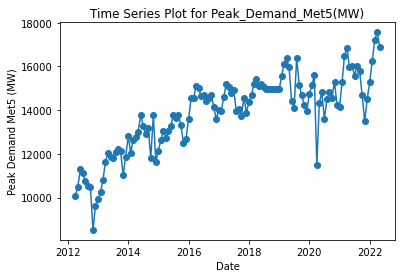

In [164]:

pyplot.plot(df["Peak_Demand_Met5(MW)"], marker='o')

# Labelling 

pyplot.xlabel("Date")
pyplot.ylabel("Peak Demand Met5 (MW)")
pyplot.title("Time Series Plot for Peak_Demand_Met5(MW)")

# Display

pyplot.show()

The graph shows that the demand has not been stationary. Inorder to model this data, we will have to first make this series as a stationary series. Then only, we would be in a postion to forecast next month's/future demand.

Different types of Stationary Time Series

a) Stationary Process: A process that generates a stationary series of observations.


b) Stationary Model: A model that describes a stationary series of observations.


c) Trend Stationary: A time series that does not exhibit a trend.


d) Seasonal Stationary: A time series that does not exhibit seasonality.


e) Strictly Stationary: A mathematical definition of a stationary process, specifically that the joint f) distribution of observations is invariant to time shift.

In [165]:
# First-order difference
df['Peak_Demand_Met5_MW_diff1'] = df['Peak_Demand_Met5(MW)'].diff(periods=1)
df = df.dropna()

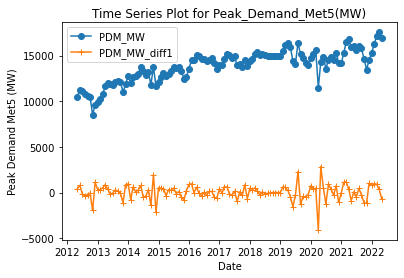

In [166]:

pyplot.plot(df["Peak_Demand_Met5(MW)"], marker='o',  label='PDM_MW')
pyplot.plot(df["Peak_Demand_Met5_MW_diff1"], marker='+', label='PDM_MW_diff1')

# Labelling 

pyplot.xlabel("Date")
pyplot.ylabel("Peak Demand Met5 (MW)")
pyplot.title("Time Series Plot for Peak_Demand_Met5(MW)")
pyplot.legend();

# Display

pyplot.show()

In [167]:
#
# Check for stationarity of the time-series data
# We will look for p-value. In case, p-value is less than 0.05, the time series
# data can said to have stationarity
#
from statsmodels.tsa.stattools import adfuller
#
# Run the test
#
df_stationarityTest = adfuller(df['Peak_Demand_Met5(MW)'], autolag='AIC')
#
# Check the value of p-value
#
print("P-value: ", df_stationarityTest[1])
#
# Next step is to find the order of AR model to be trained
# for this, we will plot partial autocorrelation plot to assess
# the direct effect of past data on future data
#
# from statsmodels.graphics.tsaplots import plot_pacf
# pacf = plot_pacf(df['Consumption'], lags=25)


P-value:  0.16621387265879534


# Training using XGBoost

In [169]:
#restructuring this time series dataset as a supervised learning problem by using the value at the previous time step to predict the value at the next time-step.
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [170]:

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [171]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    pickle.dump(model, open('Peak_Demand_Met5.pkl','wb'))
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

In [172]:
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, 1], predictions

In [173]:
#df = df.reset_index()

df1 = df[['Peak_Demand_Met5(MW)']]
#df1['date'] = df1['date'].astype(str)
df1.head()
df1.values

df2 = df[['Peak_Demand_Met5_MW_diff1']]

>expected=16040.0, predicted=12795.4
>expected=15579.0, predicted=15609.0
>expected=16029.0, predicted=14584.0
>expected=15786.0, predicted=15202.3
>expected=14675.0, predicted=14745.6
>expected=13480.0, predicted=14558.7
>expected=14501.0, predicted=14330.4
>expected=15290.0, predicted=14329.0
>expected=16262.0, predicted=14644.1
>expected=17196.0, predicted=14254.7
>expected=17563.0, predicted=15772.4
>expected=16906.0, predicted=16412.9
MAE: 1202.246


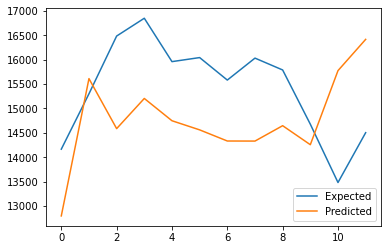

In [174]:
# load the original dataset
series = df1

values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

>expected=83.0, predicted=112.6
>expected=-461.0, predicted=223.8
>expected=450.0, predicted=498.0
>expected=-243.0, predicted=724.8
>expected=-1111.0, predicted=706.0
>expected=-1195.0, predicted=403.7
>expected=1021.0, predicted=-280.7
>expected=789.0, predicted=-866.8
>expected=972.0, predicted=126.9
>expected=934.0, predicted=318.7
>expected=367.0, predicted=442.7
>expected=-657.0, predicted=-323.0
MAE: 831.120


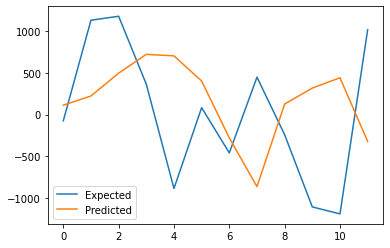

In [131]:
# load the 1st ordered differenced dataset
series = df2

values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [ ]:
df['Peak_Demand_Met5_MW_diff2'] = df['Peak_Demand_Met5(MW)'].diff(periods=2)
df = df.dropna()

In [ ]:
plt.plot(df["Peak_Demand_Met5(MW)"], marker='o',  label='PDM_MW')
plt.plot(df["Peak_Demand_Met5_MW_diff1"], marker='+', label='PDM_MW_diff1')
plt.plot(df["Peak_Demand_Met5_MW_diff2"], marker='*', label='PDM_MW_diff2')

# Labelling 

plt.xlabel("Date")
plt.ylabel("Peak Demand Met5 (MW)")
plt.title("Time Series Plot for Peak_Demand_Met5(MW)")
plt.legend();

# Display

plt.show()

In [ ]:
df3 = df[['Peak_Demand_Met5_MW_diff2']]

In [ ]:
# load the 2nd ordered differenced dataset
series = df3

values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [ ]:
# loading in the model to predict Peak_Demand_Met5_MW on the data
pickle_in = open('Peak_Demand_Met5.pkl', 'rb')
classifier = pickle.load(pickle_in)

def prediction(df):
    
    series = df

    values = series.values
# transform the time series data into supervised learning
    data = series_to_supervised(values, n_in=6)
# evaluate
    mae, y, yhat = walk_forward_validation(data, 12)
   # print('MAE: %.3f' % mae)
    # plot expected vs preducted
    f=pyplot.figure()
    pyplot.plot(y, label='Expected')
    pyplot.plot(yhat, label='Predicted')
 #   pyplot.title(titlename)
    pyplot.legend()
   # st.plotly_chart(f)
    pyplot.show()
    